# Packages

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy import optimize
from astropy.io import fits
import pandas as pd
import os

# Functions

In [274]:
#Reading data files

def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while arr[i] < x:
        i += 1
    return i
    
def readSpec(csvFile):
    #csvFile: objName, expt_ch1, expt_ch2, expt_ch3, expt_ch4, longitude, latitude, ...
    specFile = pd.read_csv(csvFile)
    dataInfo = np.array(specFile)
    fileNo = np.ma.size(dataInfo,axis=0)
    exptArr = np.zeros((fileNo,4))
    longArr = np.zeros(fileNo)
    latArr = np.zeros(fileNo)
    for i in range(fileNo):
        exptArr[i,0] = dataInfo[i,1]  #s
        exptArr[i,1] = dataInfo[i,2]  #s
        exptArr[i,2] = dataInfo[i,3]  #s
        exptArr[i,3] = dataInfo[i,4]  #s
        longArr[i] = dataInfo[i,5]  #rad
        latArr[i] = dataInfo[i,6]  #rad
    print('No. of files:', fileNo)
    print('Total exposure time:', np.sum(exptArr)/4)
    return exptArr, longArr, latArr
    
def readFits(DirName, plotSpec=True):

    #Read .fits:
    visFile = [file for file in os.listdir(DirName) if not file.startswith('.')]
    for fitsFile in visFile:
        if 'ch1' in fitsFile:
            hdul_ch1 = fits.open(DirName+'/'+fitsFile)
        elif 'ch2' in fitsFile:
            hdul_ch2 = fits.open(DirName+'/'+fitsFile)
        elif 'ch3' in fitsFile:
            hdul_ch3 = fits.open(DirName+'/'+fitsFile)
        elif 'ch4' in fitsFile:
            hdul_ch4 = fits.open(DirName+'/'+fitsFile)

    #Physical quantities:
    wvlName = 'WAVELENGTH'
    fluxName = 'BACKGROUND'
    errorName = 'BKGD_ERROR'
    wvl_ch1 = hdul_ch1[1].data[wvlName]
    flux_ch1 = hdul_ch1[1].data[fluxName]
    bkgdErr_ch1 = hdul_ch1[1].data[errorName]
    wvl_ch2 = hdul_ch2[1].data[wvlName]
    flux_ch2 = hdul_ch2[1].data[fluxName]
    bkgdErr_ch2 = hdul_ch2[1].data[errorName]
    wvl_ch3 = hdul_ch3[1].data[wvlName]
    flux_ch3 = hdul_ch3[1].data[fluxName]
    bkgdErr_ch3 = hdul_ch3[1].data[errorName]
    wvl_ch4 = hdul_ch4[1].data[wvlName]
    flux_ch4 = hdul_ch4[1].data[fluxName]
    bkgdErr_ch4 = hdul_ch4[1].data[errorName]
    data_ch1 = np.array([wvl_ch1,flux_ch1,bkgdErr_ch1])
    data_ch2 = np.array([wvl_ch2,flux_ch2,bkgdErr_ch2])
    data_ch3 = np.array([wvl_ch3,flux_ch3,bkgdErr_ch3])
    data_ch4 = np.array([wvl_ch4,flux_ch4,bkgdErr_ch4])

    #Preview spectrum:
    if (plotSpec==True):
        #Basic info:
        print("Channel 1:")
        print("Wavelength range:", (wvl_ch1[0],wvl_ch1[-1]))
        print("Array shape:", wvl_ch1.shape)
        print("Bin size (dlmd):", wvl_ch1[1]-wvl_ch1[0])
        print("Channel 2:")
        print("Wavelength range:", (wvl_ch2[0],wvl_ch2[-1]))
        print("Array shape:", wvl_ch2.shape)
        print("Bin size (dlmd):", wvl_ch2[1]-wvl_ch2[0])
        print("Channel 3:")
        print("Wavelength range:", (wvl_ch3[0],wvl_ch3[-1]))
        print("Array shape:", wvl_ch3.shape)
        print("Bin size (dlmd):", wvl_ch3[1]-wvl_ch3[0])
        print("Channel 4:")
        print("Wavelength range:", (wvl_ch4[0],wvl_ch4[-1]))
        print("Array shape:", wvl_ch4.shape)
        print("Bin size (dlmd):", wvl_ch4[1]-wvl_ch4[0])

        plt.figure(figsize=(9,3))
        plt.step(wvl_ch1,flux_ch1)
        plt.step(wvl_ch2,flux_ch2)
        plt.step(wvl_ch3,flux_ch3)
        plt.step(wvl_ch4,flux_ch4)
        plt.yscale('log')
        #plt.xlim(5,7)
        #plt.xscale('log')
        #plt.ylim(1,5000)
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.title("Spectrum preview")

    return data_ch1, data_ch2, data_ch3, data_ch4

def readFitsDir(Dir):
    visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
    data_ch1, data_ch2, data_ch3, data_ch4 = readFits(Dir+'/'+visFile[0],plotSpec=False)
    fileNo = len(visFile)
    binNo1 = np.ma.size(data_ch1,axis=1)
    binNo2 = np.ma.size(data_ch2,axis=1)
    binNo3 = np.ma.size(data_ch3,axis=1)
    binNo4 = np.ma.size(data_ch4,axis=1)
    Ch1Arr = np.zeros((fileNo,3,binNo1))
    Ch2Arr = np.zeros((fileNo,3,binNo2))
    Ch3Arr = np.zeros((fileNo,3,binNo3))
    Ch4Arr = np.zeros((fileNo,3,binNo4))
    for i in range(fileNo):
        fileName = visFile[i]
        Ch1Arr[i,:,:], Ch2Arr[i,:,:], Ch3Arr[i,:,:], Ch4Arr[i,:,:] = readFits(Dir+'/'+fileName,plotSpec=False)
        #print(data_ch1)
    return Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr
        
def stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,interp=False):
    
    fileNo = np.ma.size(Ch1Arr,axis=0)
    binNo1 = np.ma.size(Ch1Arr,axis=2)
    binNo2 = np.ma.size(Ch2Arr,axis=2)
    binNo3 = np.ma.size(Ch3Arr,axis=2)
    binNo4 = np.ma.size(Ch4Arr,axis=2)
    flux_ch1 = np.zeros(binNo1)
    flux_ch2 = np.zeros(binNo2)
    flux_ch3 = np.zeros(binNo3)
    flux_ch4 = np.zeros(binNo4)
    dn_total_ch1 = np.zeros(binNo1)
    dn_total_ch2 = np.zeros(binNo2)
    dn_total_ch3 = np.zeros(binNo3)
    dn_total_ch4 = np.zeros(binNo4)
    exptime = np.zeros(fileNo)
    SNR = np.zeros(fileNo)
    
    for i in range(fileNo):
        exptTotal = np.sum(exptArr[0:i+1,:],axis=0)
        exptime[i] = np.mean(exptTotal)
        if (interp==True):
            #Interp flux at new wavelengths
            Ch1Arr[i,1,:] = np.interp(Ch1Arr[0,0,:],Ch1Arr[i,0,:],Ch1Arr[i,1,:])
            Ch2Arr[i,1,:] = np.interp(Ch2Arr[0,0,:],Ch2Arr[i,0,:],Ch2Arr[i,1,:])
            Ch3Arr[i,1,:] = np.interp(Ch3Arr[0,0,:],Ch3Arr[i,0,:],Ch3Arr[i,1,:])
            Ch4Arr[i,1,:] = np.interp(Ch4Arr[0,0,:],Ch4Arr[i,0,:],Ch4Arr[i,1,:])
            Ch1Arr[i,2,:] = np.interp(Ch1Arr[0,0,:],Ch1Arr[i,0,:],Ch1Arr[i,2,:])
            Ch2Arr[i,2,:] = np.interp(Ch2Arr[0,0,:],Ch2Arr[i,0,:],Ch2Arr[i,2,:])
            Ch3Arr[i,2,:] = np.interp(Ch3Arr[0,0,:],Ch3Arr[i,0,:],Ch3Arr[i,2,:])
            Ch4Arr[i,2,:] = np.interp(Ch4Arr[0,0,:],Ch4Arr[i,0,:],Ch4Arr[i,2,:])
        flux_ch1 += Ch1Arr[i,1,:]*exptArr[i,0]
        flux_ch2 += Ch2Arr[i,1,:]*exptArr[i,1]
        flux_ch3 += Ch3Arr[i,1,:]*exptArr[i,2]
        flux_ch4 += Ch4Arr[i,1,:]*exptArr[i,3]
        #Propagation of error
        dn_total_ch1 += Ch1Arr[i,2,:]*exptArr[i,0]*Ch1Arr[i,2,:]*exptArr[i,0]
        dn_total_ch2 += Ch2Arr[i,2,:]*exptArr[i,1]*Ch2Arr[i,2,:]*exptArr[i,1]
        dn_total_ch3 += Ch3Arr[i,2,:]*exptArr[i,2]*Ch3Arr[i,2,:]*exptArr[i,1]
        dn_total_ch4 += Ch4Arr[i,2,:]*exptArr[i,3]*Ch4Arr[i,2,:]*exptArr[i,1]
        #Standard deviation:
        var_ch1 = np.zeros(binNo1)
        var_ch2 = np.zeros(binNo2)
        var_ch3 = np.zeros(binNo3)
        var_ch4 = np.zeros(binNo4)
        for j in range(i+1):
            var_ch1 += (Ch1Arr[j,1,:] - flux_ch1/exptTotal[0])**2*exptArr[j,0]/exptTotal[0]
            var_ch2 += (Ch2Arr[j,1,:] - flux_ch2/exptTotal[1])**2*exptArr[j,1]/exptTotal[1]
            var_ch3 += (Ch3Arr[j,1,:] - flux_ch3/exptTotal[2])**2*exptArr[j,2]/exptTotal[2]
            var_ch4 += (Ch4Arr[j,1,:] - flux_ch4/exptTotal[3])**2*exptArr[j,3]/exptTotal[3]
        NSR = np.concatenate((np.sqrt(var_ch1)/flux_ch1,np.sqrt(var_ch2)/flux_ch2,np.sqrt(var_ch3)/flux_ch3,np.sqrt(var_ch4)[:-20]/flux_ch4[:-20]))
        if (i==0):
            SNR[i] = 0
        else:
            SNR[i] = 1/np.mean(NSR)/exptime[i]
    flux_ch1 = flux_ch1/exptTotal[0]
    flux_ch2 = flux_ch2/exptTotal[1]
    flux_ch3 = flux_ch3/exptTotal[2]
    flux_ch4 = flux_ch4/exptTotal[3]
    err_ch1 = np.sqrt(dn_total_ch1)/exptTotal[0]
    err_ch2 = np.sqrt(dn_total_ch2)/exptTotal[1]
    err_ch3 = np.sqrt(dn_total_ch3)/exptTotal[2]
    err_ch4 = np.sqrt(dn_total_ch4)/exptTotal[3]

    if not(np.all(err_ch1>0)):
        print('1')
        for i in range(binNo1):
            if not(err_ch1[i]>0):
                err_ch1[i] = np.sqrt(var_ch1[i])
    elif not(np.all(err_ch2>0)):
        print('2')
        for i in  range(binNo2):
            if not(err_ch2[i]>0):
                err_ch4[i] = np.sqrt(var_ch4[i])   
    elif not(np.all(err_ch3>0)):
        print('3')
        for i in  range(binNo3):
            if not(err_ch3[i]>0):
                err_ch3[i] = np.sqrt(var_ch3[i])
    elif not(np.all(err_ch4>0)):
        print('4')
        for i in  range(binNo4):
            if not(err_ch4[i]>0):
                err_ch4[i] = np.sqrt(var_ch4[i])

    stkdata_ch1 = np.array([Ch1Arr[0,0,:],flux_ch1,err_ch1])
    stkdata_ch2 = np.array([Ch2Arr[0,0,:],flux_ch2,err_ch2])
    stkdata_ch3 = np.array([Ch3Arr[0,0,:],flux_ch3,err_ch3])
    stkdata_ch4 = np.array([Ch4Arr[0,0,:],flux_ch4,err_ch4])
    return stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime

def previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=5.350, M2=5.525, Ch1Arr=[],Ch2Arr=[],Ch3Arr=[],Ch4Arr=[]):
    wvl_ch1, flux_ch1, err_ch1 = stkdata_ch1
    wvl_ch2, flux_ch2, err_ch2 = stkdata_ch2
    wvl_ch3, flux_ch3, err_ch3 = stkdata_ch3
    wvl_ch4, flux_ch4, err_ch4 = stkdata_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))  
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]
    
    plt.figure(figsize=(9,6))
    plt.subplot(211)  
    plt.step(wvl,flux,'black',linewidth=2.5,label='Stacked')
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (Jy/sr)")
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(0, 0.3)
    plt.legend()
    
    plt.subplot(212)
    plt.step(wvlCut,fluxCut,'black',label='Stacked')
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver',linewidth=2.5)
    #plt.ylim(0.08,0.14)
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (Jy/sr)")
    plt.tight_layout(pad=0.9)
    plt.legend()

    if not(len(Ch1Arr)==0):
            fileNo = np.ma.size(Ch1Arr,axis=0)
            data_unstk = np.concatenate((Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr),axis=2)
            for  i in range(fileNo):
                wvlCut_unstk, fluxCut_unstk, errorCut_unstk = data_unstk[i,:,p1:p2]
                plt.subplot(211) 
                plt.step(data_unstk[i,0,:],data_unstk[i,1,:],linestyle='dotted',linewidth=0.3)
                plt.subplot(212)
                plt.step(wvlCut_unstk,fluxCut_unstk,linestyle='dotted',linewidth=0.5)
                plt.fill_between(wvlCut_unstk,fluxCut_unstk+errorCut_unstk,fluxCut_unstk-errorCut_unstk,step="pre",color='silver')

def linReg(xarr,yarr):
    f = lambda p,x : p[0]*x+p[1]
    lsq = lambda p : np.sum((yarr - f(p,xarr))**2)
    minitial = (yarr[-1]-yarr[0])/(xarr[-1]-xarr[0])
    pinitial = np.array([minitial,yarr[0]-minitial*xarr[0]])
    minlsq = optimize.minimize(lsq,pinitial)
    return minlsq.x, minlsq.fun

# Read fits

In [242]:
#Read data's specifications:
exptArr, longArr, latArr = readSpec('MRS_objects.csv')
print(exptArr)

No. of files: 10
Total exposure time: 192079.576
[[12183.856 12183.856 12183.856 12183.856]
 [29814.624 29814.624 29814.624 29814.624]
 [ 9890.424  9890.424  9890.424  9890.424]
 [19780.848 19780.848 19780.848 19780.848]
 [13760.592 13760.592 13760.592 13760.592]
 [10320.444 10320.444 10320.444 10320.444]
 [30961.332 30961.332 30961.332 30961.332]
 [21500.928 21500.928 21500.928 21500.928]
 [10611.756 10611.756 10611.756 10611.756]
 [33254.772 33254.772 33254.772 33254.772]]


In [243]:
#Read data:
Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr = readFitsDir("MRS_data")

## Samples

In [268]:
#Sample file
fitsFile_ch1 = "MRS_data/jw03368-c1012_t029_miri/x1d_ch1.fits"
sub1_ch1 = fits.open(fitsFile_ch1)
# fitsFile_ch2 = "MRS_data/jw02260-o003_t003_miri/JWST/jw02260-o005_t005_miri_ch2-shortmediumlong/jw02260-o005_t005_miri_ch2-shortmediumlong_x1d.fits"
# sub1_ch2 = fits.open(fitsFile_ch2)
# fitsFile_ch3 = "MRS_data/jw02260-o003_t003_miri/JWST/jw02260-o005_t005_miri_ch3-shortmediumlong/jw02260-o005_t005_miri_ch3-shortmediumlong_x1d.fits"
# sub1_ch3 = fits.open(fitsFile_ch3)
# fitsFile_ch4 = "MRS_data/jw02260-o003_t003_miri/JWST/jw02260-o005_t005_miri_ch4-shortmediumlong/jw02260-o005_t005_miri_ch4-shortmediumlong_x1d.fits"
# sub1_ch4 = fits.open(fitsFile_ch4)
print(sub1_ch1.info())
print('###############################################################################')
print(sub1_ch1[1].header)
#0th HDU: Info of data (including calibration)
#1st HDU: Data
#2nd HDU: Additional info of data

Filename: MRS_data/jw03368-c1012_t029_miri/x1d_ch1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     374   ()      
  1  EXTRACT1D     1 BinTableHDU     69   3438R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [67893B]   
None
###############################################################################
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  140 / length of dimension 1                          NAXIS2  =                 3438 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS 

Channel 1:
Wavelength range: (4.900400095357327, 7.650000025896588)
Array shape: (3438,)
Bin size (dlmd): 0.0007999999797903001
Channel 2:
Wavelength range: (7.5106502288836055, 11.700550240289886)
Array shape: (3224,)
Bin size (dlmd): 0.0013000000035390258
Channel 3:
Wavelength range: (11.551250190706924, 17.978750047041103)
Array shape: (2572,)
Bin size (dlmd): 0.0024999999441206455
Channel 4:
Wavelength range: (17.70300076296553, 28.70100085856393)
Array shape: (1834,)
Bin size (dlmd): 0.006000000052154064


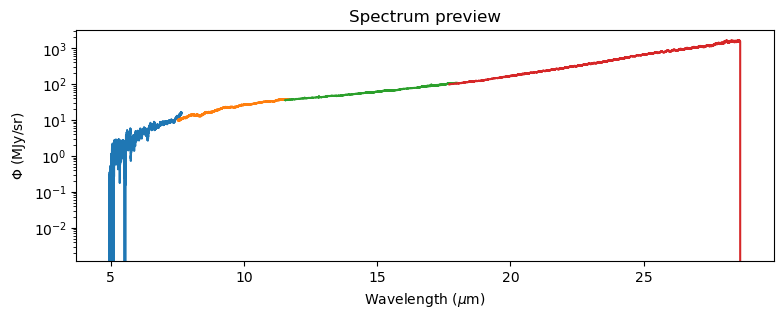

In [275]:
data_ch1, data_ch2, data_ch3, data_ch4 = readFits('MRS_data/jw01751-o015_t009_miri')

Channel 1:
Wavelength range: (4.900400095357327, 7.650000025896588)
Array shape: (3438,)
Bin size (dlmd): 0.0007999999797903001
Channel 2:
Wavelength range: (7.5106502288836055, 11.700550240289886)
Array shape: (3224,)
Bin size (dlmd): 0.0013000000035390258
Channel 3:
Wavelength range: (11.551250190706924, 17.978750047041103)
Array shape: (2572,)
Bin size (dlmd): 0.0024999999441206455
Channel 4:
Wavelength range: (17.70300076296553, 28.70100085856393)
Array shape: (1834,)
Bin size (dlmd): 0.006000000052154064


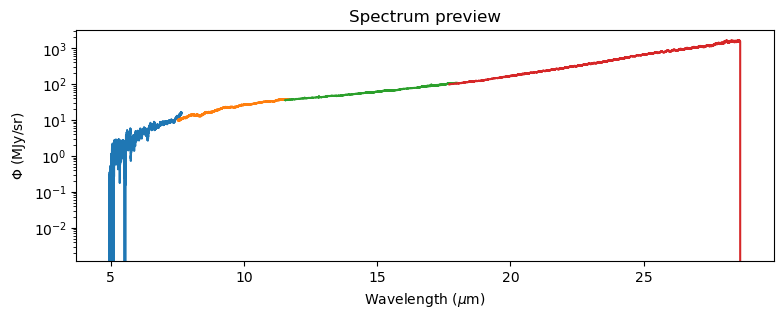

In [276]:
data_ch1, data_ch2, data_ch3, data_ch4 = readFits('MRS_data/jw01751-o015_t009_miri')

Channel 1:
Wavelength range: (4.900400095357327, 7.650000025896588)
Array shape: (3438,)
Bin size (dlmd): 0.0007999999797903001
Channel 2:
Wavelength range: (7.5106502288836055, 11.700550240289886)
Array shape: (3224,)
Bin size (dlmd): 0.0013000000035390258
Channel 3:
Wavelength range: (11.551250190706924, 17.978750047041103)
Array shape: (2572,)
Bin size (dlmd): 0.0024999999441206455
Channel 4:
Wavelength range: (17.70300076296553, 28.70100085856393)
Array shape: (1834,)
Bin size (dlmd): 0.006000000052154064


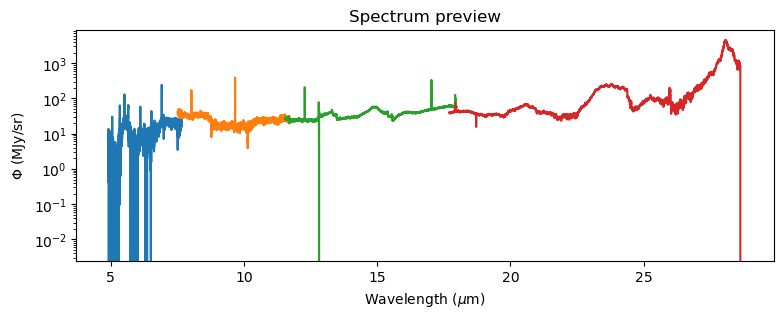

In [277]:
data_ch1, data_ch2, data_ch3, data_ch4 = readFits('MRS_unused_data/jw01706-c1001_t001_miri')

# Stack spectra

In [261]:
stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime = stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr)

4


Estimated log-signal-to-noise ratio:
[0.         7.64862361 6.64769561 5.13295063 4.96728051 4.94870296
 4.613447   4.27084123 3.9345547  3.78826894]
[-0.43374549  2.85943137]


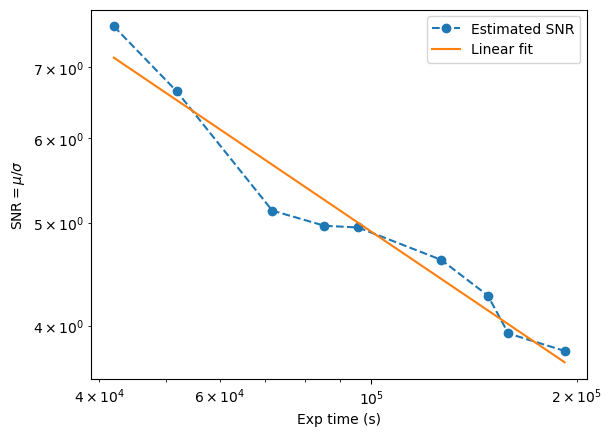

In [263]:
print('Estimated log-signal-to-noise ratio:')
print(SNR)
#print(exptime)
plt.plot(exptime[1:],SNR[1:],'--o',label='Estimated SNR')
plt.plot()
plt.ylabel('SNR$=\\mu/\\sigma$')
plt.xlabel('Exp time (s)')
plt.xscale('log')
plt.yscale('log')
#linear regression
p, lsq = linReg(np.log10(exptime[1:]),np.log10(SNR[1:]))
print(p)
plt.plot(exptime[1:],10**p[1]*exptime[1:]**p[0],'-',label='Linear fit')
plt.legend()

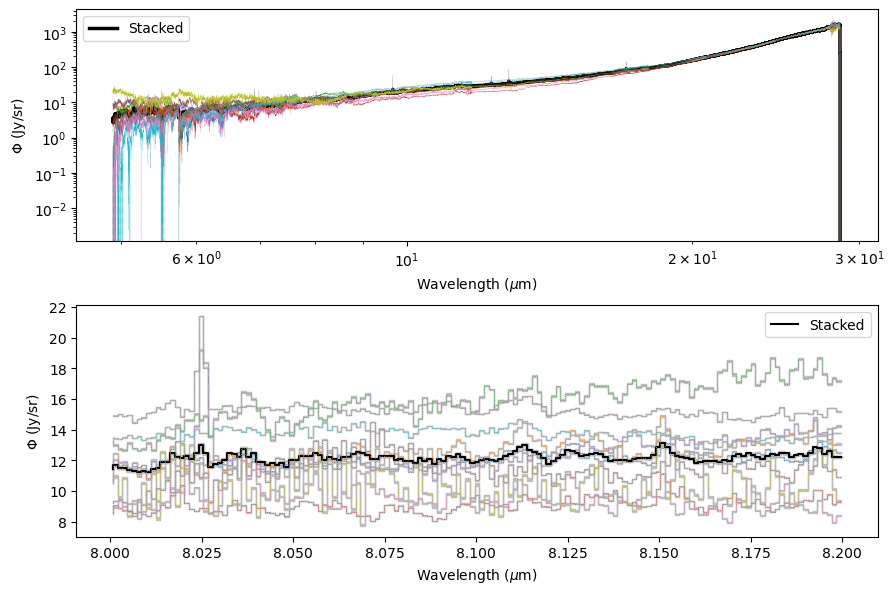

In [248]:
#Preview:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=8, M2=8.2, Ch1Arr=Ch1Arr, Ch2Arr=Ch2Arr, Ch3Arr=Ch3Arr, Ch4Arr=Ch4Arr)

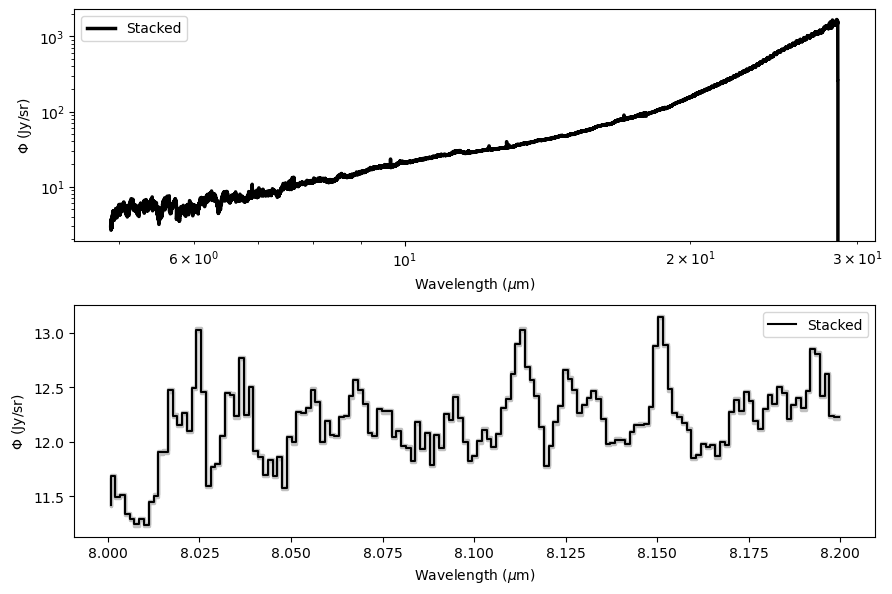

In [252]:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=8, M2=8.2)

In [51]:
#Output array files:
np.savez('stkData.npz',ch1=stkdata_ch1, ch2=stkdata_ch2, ch3=stkdata_ch3, ch4=stkdata_ch4)

In [264]:
#Output unstacked spectrum:
file_i = 1
np.savez('stkData.npz',ch1=Ch1Arr[file_i,:,:],ch2=Ch2Arr[file_i,:,:],ch3=Ch3Arr[file_i,:,:],ch4=Ch4Arr[file_i,:,:])

# Testing

In [250]:
print(Ch4Arr[2,2,-200:])

[  1.98877445   1.99507335   1.99676467   2.02038935   2.02941647
   2.02516028   2.04278207   1.9701877    1.91322112   1.95648635
   1.91020478   1.95432014   1.97274416   1.97394645   1.87732469
   1.89088937   1.77241313   1.84805081   1.96033438   1.84797555
   1.90316845   1.97210597   1.97067823   1.88605716   1.91955172
   1.96674032   2.15471127   2.11497932   2.16705805   2.2056912
   2.32518616   2.35651161   2.46497733   2.51464044   2.67360453
   2.62394512   2.74737706   2.84180761   2.92713215   3.01516532
   3.15737814   3.19919797   3.28268749   3.34724352   3.44340215
   3.53198874   3.62150141   3.66335516   3.74732521   3.70235145
   3.82137419   3.86286548   3.89253382   3.8555715    3.91818796
   3.91227301   3.96913341   4.01543953   3.94213571   4.06025732
   4.02600869   4.08716382   4.1059494    4.19853457   4.26971697
   4.54316079   4.48629714   4.64569915   4.82978393   5.00713106
   5.23961278   5.51424764   5.77372066   6.00246698   6.42366128
   6.705777

In [251]:
print(stkdata_ch4[2,-200:])

[  0.73616798   0.72142201   0.73238929   0.79158071   0.78910713
   0.73377038   0.72863318   0.77599851   0.76515378   0.77844384
   0.78328545   0.74812094   0.72545346   0.75217757   0.76314764
   0.72312926   0.77415975   0.76067058   0.74894591   0.75125861
   0.86910235   0.82921926   0.796977     0.83184999   0.81741972
   0.7701422    0.80870396   0.81875753   0.8753559    0.86280701
   0.89672119   0.89720729   0.82048176   1.1409934    0.95268704
   0.94294168   0.97165197   0.9161649    1.03111614   1.12988806
   1.13282598   1.12207776   1.10407706   1.24174975   1.1007566
   1.19993003   1.14324487   1.16739668   1.181272     1.24177109
   1.23497138   1.28338118   1.18947207   1.30897789   1.24557724
   1.18827138   1.34891637   1.21275742   1.29268546   1.26784982
   1.3140266    1.26937979   1.34041832   1.4030167    1.55933269
   1.46856556   1.48907715   1.46211357   1.52293962   1.49854857
   1.46974762   1.59999347   1.60711419   1.65676324   2.05283295
   2.016378

* Really small SNR + wrong power
* undefined error in ch4